Text Embedding - IMDB dataset
=============================
---
Introduction au Deep Learning  (IDLE) - S. Arias, E. Maldonado, JL. Parouty - CNRS/SARI/DEVLOG - 2020  

## Text classification using **Text embedding** :

The objective is to guess whether film reviews are **positive or negative** based on the analysis of the text. 

Original dataset can be find **[there](http://ai.stanford.edu/~amaas/data/sentiment/)**  
Note that [IMDb.com](https://imdb.com) offers several easy-to-use [datasets](https://www.imdb.com/interfaces/)  
For simplicity's sake, we'll use the dataset directly [embedded in Keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

https://www.liip.ch/en/blog/sentiment-detection-with-keras-word-embeddings-and-lstm-deep-learning-networks

What we're going to do:

 - Retrieve data
 - Preparing the data
 - Build a model
 - Train the model
 - Evaluate the result


## 1/ Init python stuff

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib

import fidle.pwk as ooo

ooo.init()

IDLE 2020 - Practical Work Module
  Version            : 0.2
  Run time           : Friday 24 January 2020, 09:13:23
  Matplotlib style   : fidle/talk.mplstyle
  TensorFlow version : 2.0.0
  Keras version      : 2.2.4-tf


## 2/ Retrieve data

**From Keras :**
This IMDb dataset can bet get directly from [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  

Due to their nature, textual data can be somewhat complex.

#### Data structure :  
The dataset is composed of 2 parts: **reviews** and **opinions** (positive/negative),  with a **dictionary**

  - dataset = (reviews, opinions)
    - reviews = \[ review_0, review_1, ...\]
      - review_i = [ int1, int2, ...] where int_i is the index of the word in the dictionary.
    - opinions = \[ int0, int1, ...\] where int_j == 0 if opinion is negative or 1 if opinion is positive.
  - dictionary = \[ mot1:int1, mot2:int2, ... ]

### 2.1/ Get dataset
For simplicity, we will use a pre-formatted dataset.  
See : https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data  

However, Keras offers some usefull tools for formatting textual data.  
See : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text

In [37]:
imdb = keras.datasets.imdb

# ----- Retrieve x,y
#
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words  = 10000,    
                                                       skip_top   = 0,
                                                       maxlen     = None,
                                                       seed       = 42,
                                                       start_char = 1,
                                                       oov_char   = 2,
                                                       index_from = 3, )

In [38]:
print("  x_train : {}  y_train : {}".format(x_train.shape, y_train.shape))
print("  x_test  : {}  y_test  : {}".format(x_test.shape,  y_test.shape))

print('\nReview example (x_train[12]) :\n\n',x_train[12])

  x_train : (25000,)  y_train : (25000,)
  x_test  : (25000,)  y_test  : (25000,)

Review example (x_train[12]) :

 [1, 14, 22, 1367, 53, 206, 159, 4, 636, 898, 74, 26, 11, 436, 363, 108, 7, 14, 432, 14, 22, 9, 1055, 34, 8599, 2, 5, 381, 3705, 4509, 14, 768, 47, 839, 25, 111, 1517, 2579, 1991, 438, 2663, 587, 4, 280, 725, 6, 58, 11, 2714, 201, 4, 206, 16, 702, 5, 5176, 19, 480, 5920, 157, 13, 64, 219, 4, 2, 11, 107, 665, 1212, 39, 4, 206, 4, 65, 410, 16, 565, 5, 24, 43, 343, 17, 5602, 8, 169, 101, 85, 206, 108, 8, 3008, 14, 25, 215, 168, 18, 6, 2579, 1991, 438, 2, 11, 129, 1609, 36, 26, 66, 290, 3303, 46, 5, 633, 115, 4363]


### 2.2/ Have a look for humans (optional)
When we loaded the dataset, we asked for using \<start\> as 1, \<unknown word\> as 2  
So, we shifted the dataset by 3 with the parameter index_from=3

In [53]:
# ---- Retrieve dictionary {word:index}

word_index = imdb.get_word_index()

# ---- Shift the dictionary from +3

word_index = {w:(i+3) for w,i in word_index.items()}

# ---- Add <pad>, <start> and unknown tags

word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2} )

# ---- Create a reverse dictionary : {index:word}

index_word = {(index):word for word,index in word_index.items()} 

# ---- Add a nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])

In [49]:
print('\nDictionary size     : ', len(word_index))
print('\nReview example (x_train[12]) :\n\n',x_train[12])
print('\nIn real words :\n\n', dataset2text(x_train[12]))


Dictionary size     :  88587

Review example (x_train[12]) :

 [1, 14, 22, 1367, 53, 206, 159, 4, 636, 898, 74, 26, 11, 436, 363, 108, 7, 14, 432, 14, 22, 9, 1055, 34, 8599, 2, 5, 381, 3705, 4509, 14, 768, 47, 839, 25, 111, 1517, 2579, 1991, 438, 2663, 587, 4, 280, 725, 6, 58, 11, 2714, 201, 4, 206, 16, 702, 5, 5176, 19, 480, 5920, 157, 13, 64, 219, 4, 2, 11, 107, 665, 1212, 39, 4, 206, 4, 65, 410, 16, 565, 5, 24, 43, 343, 17, 5602, 8, 169, 101, 85, 206, 108, 8, 3008, 14, 25, 215, 168, 18, 6, 2579, 1991, 438, 2, 11, 129, 1609, 36, 26, 66, 290, 3303, 46, 5, 633, 115, 4363]

In real words :

 <start> this film contains more action before the opening credits than are in entire hollywood films of this sort this film is produced by tsui <unknown> and stars jet li this team has brought you many worthy hong kong cinema productions including the once upon a time in china series the action was fast and furious with amazing wire work i only saw the <unknown> in two shots aside from the action t

### 2.3/ Have a look for neurons

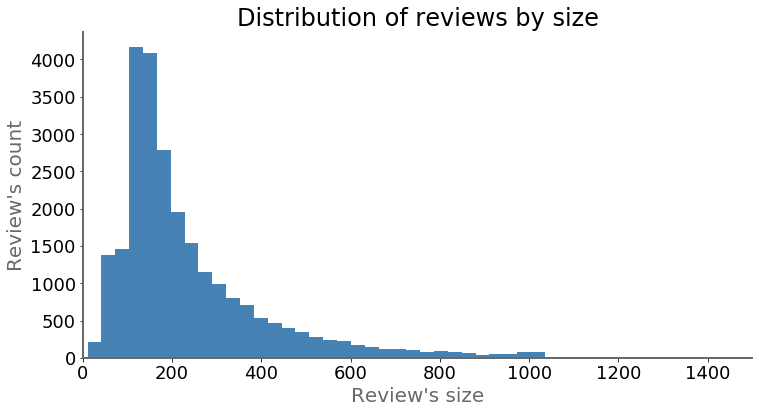

In [52]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,6)
ax.hist([len(i) for i in x_train],80 )
ax.set_title('Distribution of reviews by size')
ax.set_xlim(left=0,right=1500)
ax.set_xlabel("Review's size")
ax.set_ylabel("Review's count")
plt.show()

## Step 3 - Preprocess the data
In order to be processed by an NN, all entries must have the same length.  
We chose a maxlength of **max_len**  
We will therefore complete them with a padding (of \<pad\>\)  

In [56]:
max_len = 256

x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     value   = 0,
                                                     padding = 'post',
                                                     maxlen  = max_len)

x_test  = keras.preprocessing.sequence.pad_sequences(x_valid,
                                                     value   = 0 ,
                                                     padding = 'post',
                                                     maxlen  = max_len)

print('\nReview example (x_train[12]) :\n\n',x_train[12])
print('\nIn real words :\n\n', dataset2text(x_train[12]))


Review example (x_train[12]) :

 [   1   14   22 1367   53  206  159    4  636  898   74   26   11  436
  363  108    7   14  432   14   22    9 1055   34 8599    2    5  381
 3705 4509   14  768   47  839   25  111 1517 2579 1991  438 2663  587
    4  280  725    6   58   11 2714  201    4  206   16  702    5 5176
   19  480 5920  157   13   64  219    4    2   11  107  665 1212   39
    4  206    4   65  410   16  565    5   24   43  343   17 5602    8
  169  101   85  206  108    8 3008   14   25  215  168   18    6 2579
 1991  438    2   11  129 1609   36   26   66  290 3303   46    5  633
  115 4363    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0   

## Step 4 - Building the model
Few remarks :
1. GlobalAveragePooling1D : Fait un pooling sur la seconde dimension (batch_size, steps, features) -> (batch_size, features)  
Autrement dit : on moyenne l'ensemble des mots d'une phrase
2. L'embedding de Keras fonctionne de manière supervisée. Il s'agit d'une couche de *vocab_size* neurones vers *n_neurons* permettant de maintenir une table de vecteurs (les poids constituent les vecteurs). Cette couche ne calcule pas de sortie a la façon des couches normales, mais renvois la valeur des vecteurs. n mots => n vecteurs (ensuite empilés par le pooling)  
Voir : https://stats.stackexchange.com/questions/324992/how-the-embedding-layer-is-trained-in-keras-embedding-layer

In [16]:

vocab_size = 10000
n_neurons  = 32  # 200 pour voir overfiting

keras.backend.clear_session()

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, n_neurons, input_length=256))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(n_neurons, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks=[]
callbacks.append( keras.callbacks.ModelCheckpoint(ooo.get_check_dir()+'/model{epoch:02d}-{val_acc:.3f}.h5') )
callbacks.append( keras.callbacks.ModelCheckpoint(ooo.get_model_dir()+'/best_model.h5', save_best_only=True) )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 32)           320000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 321,089
Trainable params: 321,089
Non-trainable params: 0
_________________________________________________________________


## Entrainement

In [17]:
%%time

n_epochs   = 30
batch_size = 512

history = model.fit(x_train,
                    y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(x_valid, y_valid),
                    verbose=1,
                    callbacks=callbacks)


Train on 25000 samples, validate on 25000 samples
Epoch 1/30
25000/25000 [==============================] - 1s 60us/sample - loss: 0.6882 - acc: 0.6171 - val_loss: 0.6787 - val_acc: 0.6901
Epoch 2/30
25000/25000 [==============================] - 1s 48us/sample - loss: 0.6512 - acc: 0.7332 - val_loss: 0.6168 - val_acc: 0.7786
Epoch 3/30
25000/25000 [==============================] - 1s 51us/sample - loss: 0.5554 - acc: 0.8075 - val_loss: 0.5076 - val_acc: 0.8237
Epoch 4/30
25000/25000 [==============================] - 1s 48us/sample - loss: 0.4378 - acc: 0.8525 - val_loss: 0.4123 - val_acc: 0.8485
Epoch 5/30
25000/25000 [==============================] - 1s 49us/sample - loss: 0.3519 - acc: 0.8786 - val_loss: 0.3565 - val_acc: 0.8620
Epoch 6/30
25000/25000 [==============================] - 1s 48us/sample - loss: 0.2993 - acc: 0.8922 - val_loss: 0.3269 - val_acc: 0.8690
Epoch 7/30
25000/25000 [==============================] - 1s 49us/sample - loss: 0.2654 - acc: 0.9026 - val_loss: 0.

## Evalulation du modèle

Load best model... Done.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 32)           320000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 321,089
Trainable params: 321,089
Non-trainable params: 0
_________________________________________________________________
None
25000/25000 [==============================] - 1s 20us/sample - loss: 0.2868 - acc: 0.8816


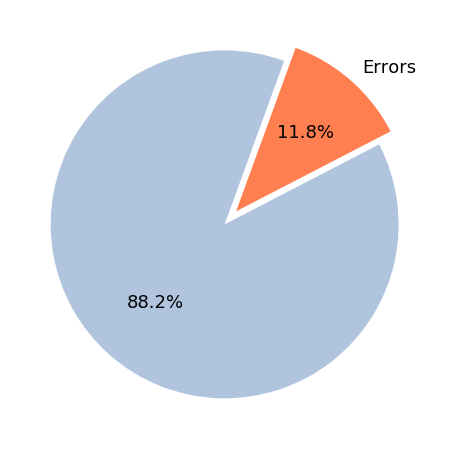

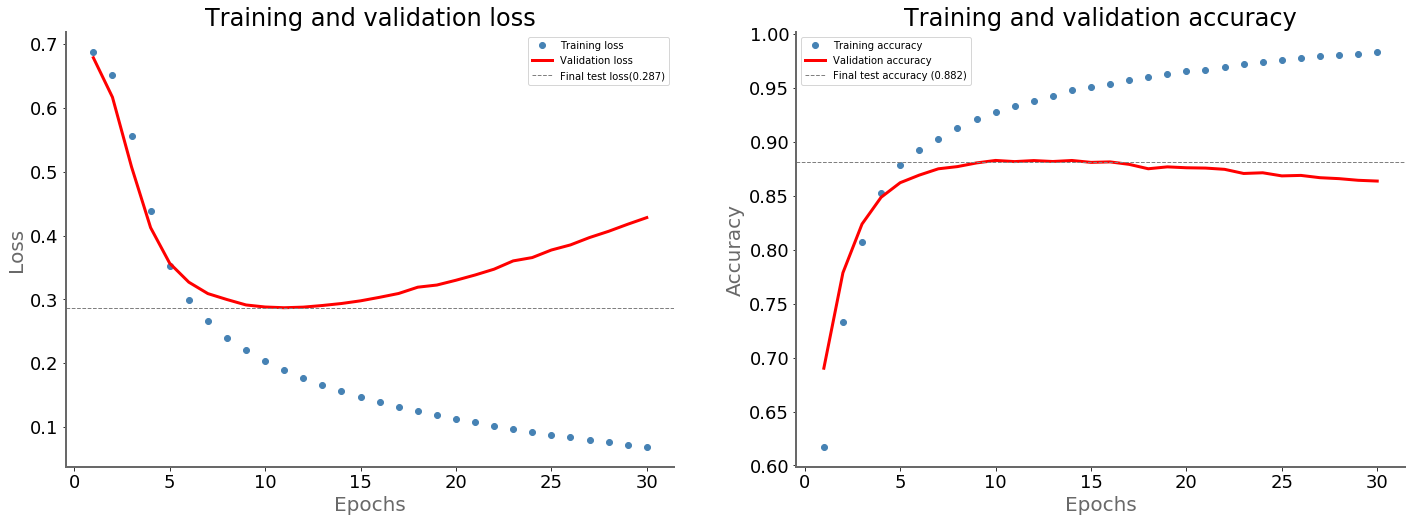

In [18]:
print('Load best model... ', end='')
model = keras.models.load_model(ooo.get_model_dir()+'/best_model.h5')
print('Done.\n')

print(model.summary())
# ------ Evaluation du résultat ------------------------------------

results  = model.evaluate(x_valid, y_valid)
accuracy = results[1]

fig, axs = plt.subplots()
fig.set_size_inches(8,8)
axs.pie([accuracy,1-accuracy], explode=[0,0.1], labels=["","Errors"], 
        autopct='%1.1f%%', shadow=False, startangle=70, 
        colors=["lightsteelblue","coral"], textprops={'fontsize': 18})
ooo.save_fig('accuracy')
plt.show()


# ------ Statistiques d'apprentissage -------------------------------

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']
x_epochs = range(1, len(acc) + 1)

fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(24,8)
ax1.plot(x_epochs, loss,     'o',  fillstyle='full',  markersize=6, color='steelblue', label='Training loss')
ax1.plot(x_epochs, val_loss, '-',  fillstyle='none',  markersize=6, color='red',       label='Validation loss')
ax1.axhline(y=results[0],          linestyle='--',    linewidth=1,  color='grey',      label='Final test loss({:5.3})'.format(results[0]))
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(x_epochs, acc,     'o',  fillstyle='full',  markersize=6, color='steelblue', label='Training accuracy')
ax2.plot(x_epochs, val_acc, '-',  fillstyle='none',  markersize=6, color='red',       label='Validation accuracy')
ax2.axhline(y=results[1],         linestyle='--',    linewidth=1,  color='grey',      label='Final test accuracy ({:5.3})'.format(results[1]))
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

ooo.save_fig("Evaluations")
plt.show()
